# Regression Analysis

In this notebook we analyze the relationship between county population and number of outgoing migrants

## Load Data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats
import sklearn.metrics

import matplotlib.pyplot as plt

from Data import *

In [2]:
startYear = 2008
stopYear = 2013

yearRange = range(startYear,stopYear+1)
populationDataFiles = [
    "data/output/population/%d_population_data.csv" % (i) for i in yearRange
]
migrationDataFiles = [
    "data/output/groundTruthOutput/%d_groundTruth_data.csv" % (i) for i in yearRange
]

populationDataSets = [loadPopulationFile(fn) for fn in populationDataFiles]
migrationDataSets = [loadMatrix(fn) for fn in migrationDataFiles]

#zero out the self migration values
for i in range(len(migrationDataSets)):
    for j in range(migrationDataSets[i].shape[0]):
        migrationDataSets[i][j,j] = 0

countyIds = loadCounties()

In [3]:
data = dict()
for i,year in enumerate(yearRange):
    popVals = []
    outgoingMigrations = []
    incomingMigrations = []
    for j,countyId in enumerate(countyIds):
        popVals.append(populationDataSets[i][j])
        outgoingMigrations.append(np.sum(migrationDataSets[i][j,:]))
        incomingMigrations.append(np.sum(migrationDataSets[i][:,j]))
        
    data["%d_population" % (year)] = popVals
    data["%d_outgoingMigration" % (year)] = outgoingMigrations
    data["%d_incomingMigration" % (year)] = incomingMigrations

df = pd.DataFrame(data, index=countyIds)

x = df["2008_population"].as_matrix()
y = df["2008_outgoingMigration"].as_matrix()
x[x<1] = 1
y[y<1] = 1

## Linear Regression

In [13]:
r2Score = sklearn.metrics.r2_score
explainedVarianceScore = sklearn.metrics.explained_variance_score
maeScore = sklearn.metrics.mean_absolute_error
mseScore = sklearn.metrics.mean_squared_error
medianaeScore = sklearn.metrics.median_absolute_error

def getMetrics(yTrue,yPred):
    
    seriesData = {
        "r^2" : r2Score(yTrue, yPred),
        "MAE" : maeScore(yTrue, yPred),
        "MSE" : mseScore(yTrue, yPred),
        "RMSE" : mseScore(yTrue, yPred)**0.5
    }
    #print pd.DataFrame(dfData, index=["r^2","MAE","MSE","RMSE"])
    data = pd.Series(seriesData)
    return data
    
    
def plotPredictionsLinear(x,yTrue,f):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    
    ax.set_ylabel('Migrants, $T_i$', size=20)
    ax.set_xlabel('Population, $m_i$', size=20)
    ax.set_title('Number of outgoing migrants from IRS data vs. Population, %d' % (2008), size=20)
    
    ax.axis([x.min(), x.max(), yTrue.min(), yTrue.max()])
        
    ax.scatter(x,yTrue,s=2,color='grey',alpha=0.75)
    xSpace = np.linspace(x.min(),x.max(),num=10000)
    yPred = f(xSpace)
    ax.plot(xSpace,yPred)
    
def plotPredictionsLog(x,yTrue,f):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    
    ax.set_ylabel('Migrants, $T_i$', size=20)
    ax.set_xlabel('Population, $m_i$', size=20)
    ax.set_title('Number of outgoing migrants from IRS data vs. Population, %d' % (2008), size=20)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.axis([x.min(), x.max(), yTrue.min(), yTrue.max()])
    #ax.axis([1e2, 1e8, 1e1, 1e6])
    
    ax.scatter(x,yTrue,s=2,color='grey',alpha=0.75)
    xSpace = np.linspace(x.min(),x.max(),num=10000)
    yPred = f(xSpace)
    ax.plot(xSpace,yPred)
    
def plotPredictionsLogProjection(x,yTrue,f,metrics,year):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    
    ax.set_ylabel('Migrants, $T_i$', size=20)
    ax.set_xlabel('Population, $m_i$', size=20)
    ax.set_title('Number of outgoing migrants from IRS data vs. Population, %d' % (year), size=20)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.axis([x.min(), x.max(), yTrue.min(), yTrue.max()])
        
    ax.text(
        1*10**5.5,
        1*10**0.5,
        "R$^2$: %0.4f" % metrics["r^2"],
        bbox=dict(facecolor='lightgrey', alpha=0.5),
        fontsize=20,
        color='black',
    )    
    
    ax.scatter(x,yTrue,s=2,color='grey',alpha=0.75)
    xSpace = np.linspace(np.log10(x.min()),np.log10(x.max()),num=10000)
    yPred = f(xSpace)
    ax.plot(10**xSpace,10**yPred)

## Linear Data Fitting

This function does a polynomial fit with a given degree with no transformations on the input data. It returns a `metric` data structure with the regression results.

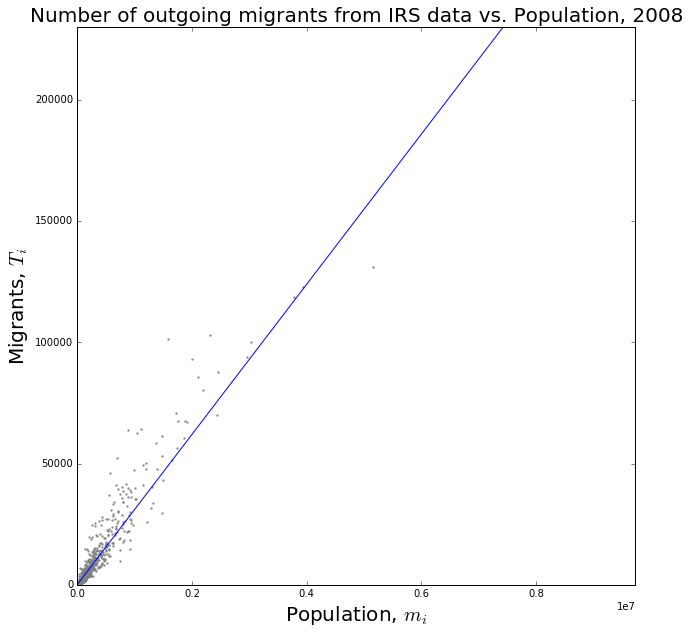

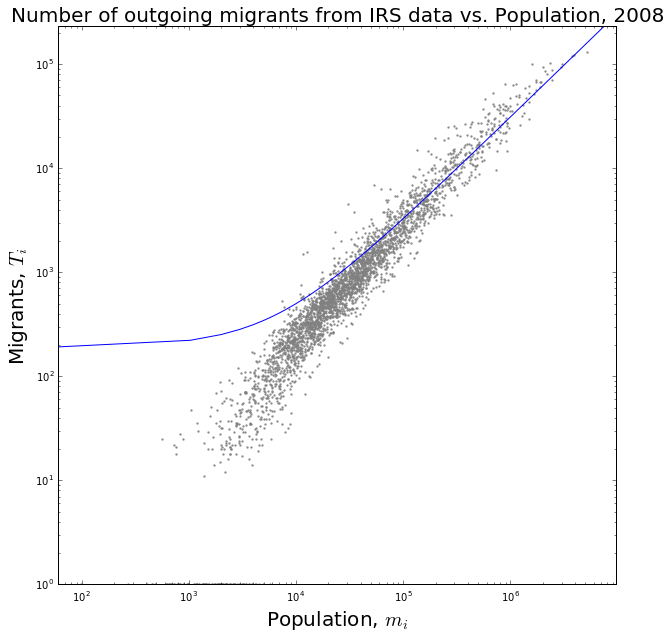

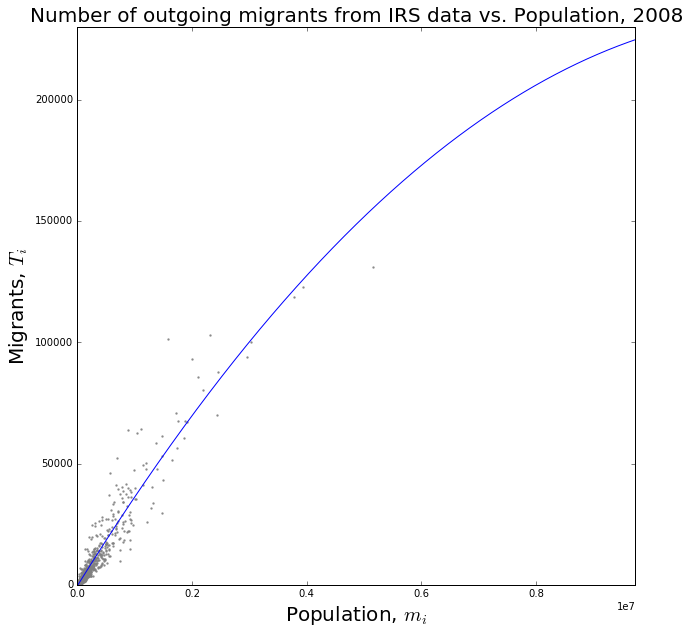

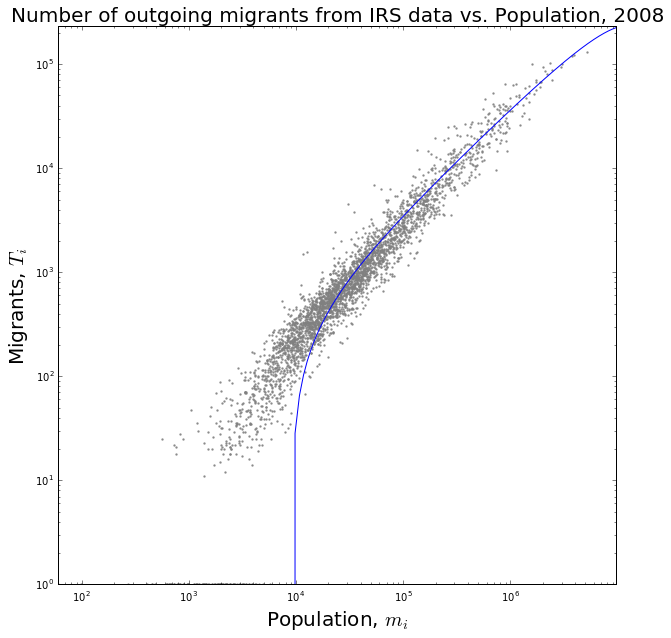

In [14]:
def linearDataFitting(x, y, fitDegree, plot=False):
    
    coeffs = np.polyfit(x, y, fitDegree)
    fitFunction = np.poly1d(coeffs)
    yPred = fitFunction(x)
        
    if plot:
        plotPredictionsLinear(x,y,fitFunction)
        plotPredictionsLog(x,y,fitFunction)
    
    return getMetrics(y,yPred)

linearData_Degree1 = linearDataFitting(x, y, 1, plot=True)
linearData_Degree2 = linearDataFitting(x, y, 2, plot=True)

## Log Data Fitting

This function transforms the input into log space then does a polynomial fit with a given degree. It returns two `metric` data structures, one with the regression results in the log space, and one re-projected into linear space.

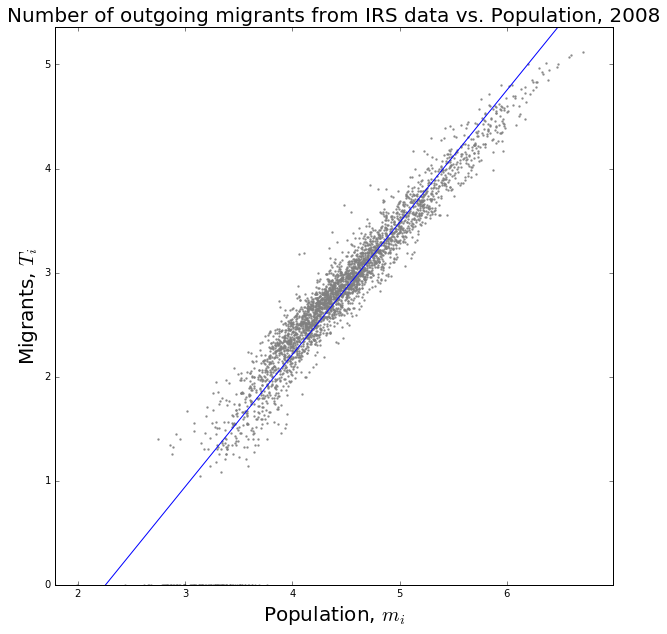

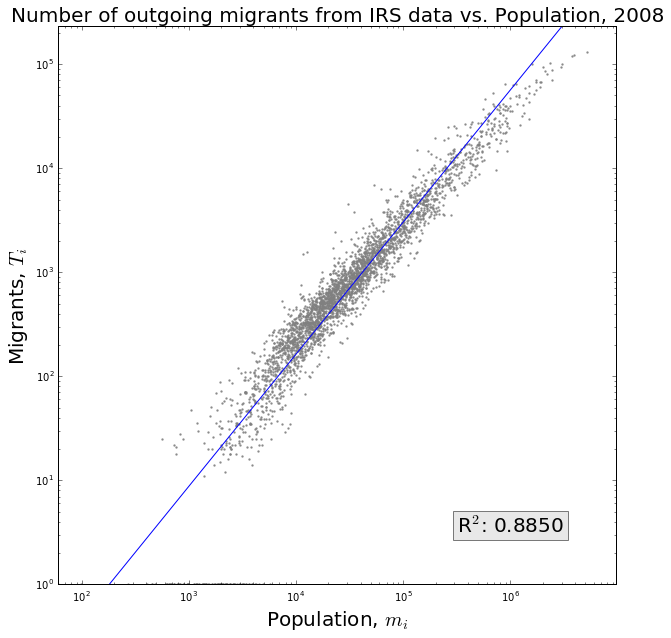

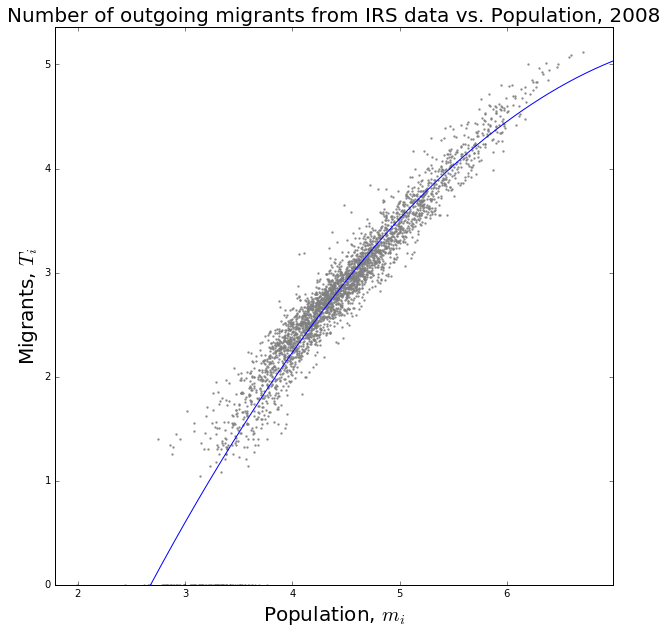

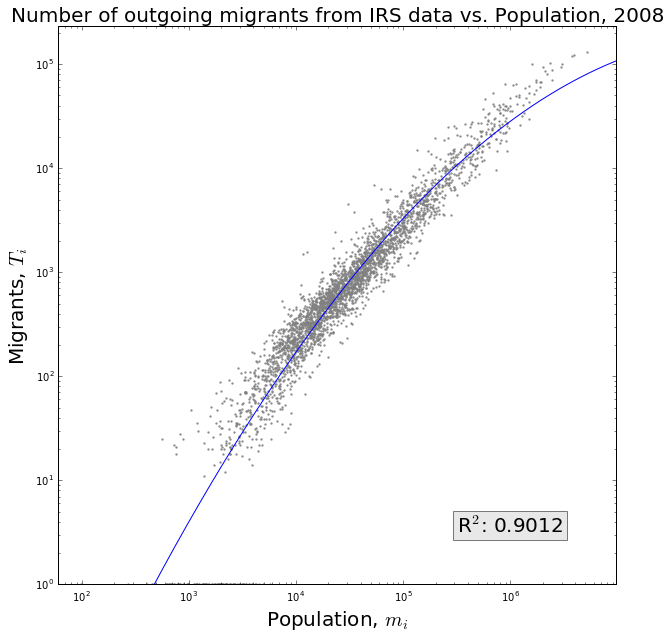

In [15]:
def loglogDataFitting(x, y, fitDegree, plot=False, year=2008):
    
    xLog = np.log10(x)
    yLog = np.log10(y)
    coeffs = np.polyfit(xLog,yLog,fitDegree)
    fitFunction = np.poly1d(coeffs)
    yPred = fitFunction(xLog)
    
    metrics1, metrics2 = getMetrics(yLog,yPred), getMetrics(10**yLog,10**yPred)
    
    if plot:
        plotPredictionsLinear(xLog,yLog,fitFunction)
        plotPredictionsLogProjection(x,y,fitFunction, metrics1, year=year)
    
    return  metrics1, metrics2


logData_Degree1_LogSpace,logData_Degree1_LinearSpace = loglogDataFitting(x, y, 1, plot=True)
logData_Degree2_LogSpace,logData_Degree2_LinearSpace = loglogDataFitting(x, y, 2, plot=True)

In [7]:
metricDataFrame = pd.DataFrame(
    {
        "linear_degree1":linearData_Degree1,
        "linear_degree2":linearData_Degree2,
        "log_degree1_logSpace":logData_Degree1_LogSpace,
        "log_degree1_linearSpace":logData_Degree1_LinearSpace,
        "log_degree2_logSpace":logData_Degree2_LogSpace,
        "log_degree2_linearSpace":logData_Degree2_LinearSpace,
    }
)
print metricDataFrame

      linear_degree1  linear_degree2  log_degree1_linearSpace  \
MAE       963.115748      858.347913             1.873415e+03   
MSE   9261684.250708  6174074.460807             3.013853e+08   
RMSE     3043.301538     2484.768492             1.736045e+04   
r^2         0.907515        0.938347            -2.009550e+00   

      log_degree1_logSpace  log_degree2_linearSpace  log_degree2_logSpace  
MAE               0.183768               992.926942              0.172215  
MSE               0.084299          19210688.716196              0.072458  
RMSE              0.290343              4382.999968              0.269180  
r^2               0.885047                 0.808167              0.901194  


In [9]:
metricDataFrame.to_csv("statsAnalysis.csv")

## Formated Output

|                         | MAE    | MSE         | RMSE    | r^2   |
|-------------------------|--------|-------------|---------|-------|
| linear_degree1          | 646.81 |  3462573.05 | 1860.80 |  0.85 |
| linear_degree2          | 461.32 |  1844400.10 | 1358.09 |  0.92 |
| log_degree1_linearSpace | 932.51 | 72378850.29 | 8507.58 | -2.09 |
| log_degree1_logSpace    |   0.17 |        0.06 |    0.24 |  0.92 |
| log_degree2_linearSpace | 452.57 |  2227063.53 | 1492.33 |  0.90 |
| log_degree2_logSpace    |   0.16 |        0.05 |    0.23 |  0.93 |

# Results Over Multiple Years

In [8]:
for year in range(2004,2010):
    x = df["%d_population" % (year)].as_matrix()
    y = df["%d_outgoingMigration" % (year)].as_matrix()
    
    goodIndexes = (x>=1) & (y>=1)
    x = x[goodIndexes]
    y = y[goodIndexes]
    
    linearData_Degree1 = linearDataFitting(x, y, 1, plot=False)
    linearData_Degree2 = linearDataFitting(x, y, 2, plot=False)
    logData_Degree1_LogSpace,logData_Degree1_LinearSpace = loglogDataFitting(x, y, 1, plot=False)
    logData_Degree2_LogSpace,logData_Degree2_LinearSpace = loglogDataFitting(x, y, 2, plot=False)
    metricDataFrame = pd.DataFrame(
        {
            "linear_degree1":linearData_Degree1,
            "linear_degree2":linearData_Degree2,
            "log_degree1_linearSpace":logData_Degree1_LinearSpace,
            "log_degree2_linearSpace":logData_Degree2_LinearSpace,
        }
    )
    print "\n\n\n%d\n------------------------------------------\n" % (year)
    print metricDataFrame
    




2004
------------------------------------------

       linear_degree1   linear_degree2  log_degree1_linearSpace  \
MAE       1667.437787      1128.852760             1.727763e+03   
MSE   20904434.281148  11389266.602894             2.099341e+08   
RMSE      4572.136730      3374.798750             1.448910e+04   
r^2          0.779454         0.879841            -1.214843e+00   

      log_degree2_linearSpace  
MAE               1128.145416  
MSE           15953410.165761  
RMSE              3994.172025  
r^2                  0.831689  



2005
------------------------------------------

       linear_degree1   linear_degree2  log_degree1_linearSpace  \
MAE       1722.331192      1190.346495             1.766804e+03   
MSE   23401362.349361  12714893.122873             2.093800e+08   
RMSE      4837.495462      3565.794880             1.446997e+04   
r^2          0.779013         0.879929            -9.772467e-01   

      log_degree2_linearSpace  
MAE               1189.216525  
